# 1. 🌐 Introduction

This Jupyter notebook is a **hands-on guide to pixel- and object-based image classification** with **RSGISLib** and **scikit-learn**.  It is an adptation of tutorials designed by Pete Bunting, available [HERE](https://github.com/remotesensinginfo/rsgislib-tutorials/blob/main/03_intro_image_classification/01_basic_ml_image_class.ipynb) and [HERE](https://github.com/remotesensinginfo/rsgislib-tutorials/blob/main/05_further_image_classification/09_existing_accuracy_points.ipynb)
Throughout the practical you will:

1. **Prepare** a Sentinel-2 subset (band stacking, index calculation).  
2. **Train** Random Forest models at the pixel and segment levels.  
3. **Build** a rule-based land-cover map using simple spectral thresholds.  
4. **Validate** the results with an independent sample set and interpret a full suite of accuracy metrics.

All intermediate and final products are stored in the **HDF5** format, allowing efficient I/O and rich metadata support.

---

## 📦 What is HDF5?

**HDF5 (Hierarchical Data Format, version 5)** is a versatile binary file standard designed to hold large, heterogeneous scientific data.

* **Hierarchical structure**  
  *Think of HDF5 as a self-contained filesystem in a single file*:  
  * **Groups**  =  folders  
  * **Datasets**  =  files (multi-dimensional arrays)  
  * **Attributes**  =  key–value metadata attached to either groups or datasets  

* **Key characteristics**  
  * Unlimited dimensions (ideal for stacks of rasters, time series, hyperspectral cubes).  
  * Built-in **compression** (e.g. `gzip`, `szip`), saving disk space without external side-cars.  
  * **Random access**: read a small slice without loading the whole file into memory.  
  * **Endianness-safe** and cross-platform (Mac / Windows / Linux).  
  * Native support in Python (`h5py`, `xarray`), MATLAB, R, GDAL, QGIS and many EO libraries.

* **Why we use it here**  
  * A single `.h5` keeps the imagery, intermediate masks, textural layers **and** the model outputs in one portable package.  
  * We can attach provenance—sensor name, acquisition date, classifier parameters—straight into the file as attributes, guaranteeing anyone who re-opens the data knows exactly how it was created.

---

## 👁️ Browsing the file with **HDFView**

While Python scripts are perfect for automation, a graphical inspector is invaluable when you first meet an unfamiliar HDF5 file.  
We will use **HDFView** (The HDF Group’s official viewer):

1. **Download & install**  
   *Latest version*: <https://www.hdfgroup.org/download-hdfview/>  
   Choose the installer for your operating system; Java Runtime is bundled.

2. **Opening a file**  
   *File → Open* → select `your_dataset.h5`.  
   The left panel shows the tree of **groups** and **datasets**; the right panel previews the content.

3. **Exploring datasets**  
   * Double-click a dataset to view its array values.  
   * Use the *Table* or *Image* tab to change visualisation mode (useful for 2-D rasters).  
   * Right-click → *Show Properties* to inspect **attributes** (e.g. CRS, wavelength).

4. **Advantages for teaching**  
   * Students can **visually grasp** the nested structure and metadata without writing a single line of code.  
   * Quick sanity checks (shape, min–max values) before feeding data into a model.  
   * Export slices to CSV or PNG for presentations.

---

## 📝 Metadata you can record

| Category | Suggested attribute key | Example value |
|----------|------------------------|---------------|
| Acquisition | `sensor`, `acq_date` | `"Sentinel-2 MSI"`, `"2024-07-12"` |
| Pre-processing | `atm_corr`, `indices` | `"Sen2Cor 2.10"`, `"NDVI, NDWI, NDBI"` |
| Classifier details | `model_type`, `rf_n_estimators`, `rf_max_depth` | `"RandomForest"`, `300`, `12` |
| Validation | `oa`, `kappa`, `macro_f1` | `0.88`, `0.84`, `0.85` |

Adding attributes in Python is a one-liner with **h5py**:

```python
import h5py
with h5py.File("classified_map.h5", "a") as f:
    f.attrs["sensor"] = "Sentinel-2 MSI"
    f["/classification"].attrs["model_type"] = "RandomForest"


# 2. 🌐 Import modules

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

# 3.🌐 Allocate input data into variables

Declare the **core inputs** for the classification exercise:

| Variable | File | Purpose |
|----------|------|---------|
| `input_img` | `sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif` | Multispectral Sentinel-2 scene (20 m spatial resolution) to be classified. The file is already surface-reflectance corrected and projected to the British National Grid (OSGB, EPSG 27700). |
| `in_msk_img` | `sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif` | Valid-pixel mask for the same scene. It identifies pixels that should be ignored (cloud, edge, detector gaps). For this subset every pixel happens to be valid, yet RSGISLib routines still expect an explicit mask. |
| `vec_train_file` | `aber_sen2_cls_training.gpkg` | Vector layer containing the **training points** (or small polygons). Each record is labelled with a land-cover class ID; the spectral values under these points will train the Random Forest. |

> **Why bother with a mask?**  
> Even when the entire tile looks valid, many EO processing chains expect a companion mask so they can seamlessly handle scenes with clouds or missing lines. Providing one now ensures the exact same workflow will run on less pristine images later on.



In [4]:
# Input Sentinel-2 image file with 20 m resolution pixels.
input_img = "./Data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"

# A valid pixel mask for the input image - this is required for later
# steps but note that for this particular image all the pixel values
# are valid (i.e., there aren't are no data regions).
in_msk_img = "./Data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif"

vec_train_file = "./Data/aber_sen2_cls_training.gpkg"

Samples are defined using polygon or point vector layers. Each layer represents a class, and within that layer, multiple polygons/points are used to identify pixels belonging to the class of interest. Note the vector layer needs to be the same projection as the input image(s). In this case samples are defined using vector layers. 

Remember, when defining your reference dataset, you want to ensure you get a similar number of pixels sampled for all classes. This might be problematic for classes which are limited in geographic coverage. However, you also want to ensure you get good geographic coverage and don't have a small number of large polygons that are all geographically clustered - this can result in an overestimation of your classifier accuracy due to overfitting caused by spatial autocorrelation.

For this analysis, the following Geopackage (GPKG) file as a set of layers defining the training data. Open the layers in a GIS and examine them before preceeding with the tutorial. After you have run through the tutorial you might consider revising this reference data and rerunning the classifications and seeing what difference it makes.


# 🌐 4 Explore your data

Get the list of layers within the vector file.

In [5]:
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )


['Artificial_Surfaces', 'Bare_Rock_Sand', 'Conifer_Forest', 'Deciduous_Forest', 'Grass_Long', 'Grass_Short', 'NonPhotosynthetic_Vegetation', 'Scrub', 'Water_Training', 'Bracken']


## 4.1. Visualise the training data

It is recommended that you open the input image (`sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif`) and training samples (`aber_sen2_cls_training.gpkg`) in QGIS (or equivlent) to see the regions which have been defined for training as this allows you to manipulate (i.e., pan and zoom) the data.

However, an overview visualisation is shown below for illustration. If you change the bounding box you can pan and zoom around scene. Note the training samples are quite small compared to the whole scene and therefore can be hard to see.


In [6]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

(249177.3321426216, 315077.3321426216, 268742.255157026, 326342.255157026)


The following cell creates a single map that overlays our **Sentinel-2 composite** with the **training points/polygons**. The aim is to confirm that every sample truly sits on its intended land-cover type.

* **Bounding box**  
Clip the display to `sub_img_bbox = [275 000, 300 000, 275 000, 300 000]` (min-x, max-x, min-y, max-y in OSGB metres). This 25 km × 25 km window keeps the figure concise while covering all training layers.

* **Base image (bands 8-9-3)**  
  `rsgislib.tools.mapping.create_raster_img_map` draws a pseudo-RGB composite using Sentinel-2 bands 8 (NIR), 9 (red-edge) and 3 (green). A cumulative-histogram stretch enhances local contrast and a scale bar is added automatically.

* **Random colours for each land-cover class**  
  Pull Matplotlib’s full CSS4 palette (`mcolors.CSS4_COLORS`) and assign a different random hue to every layer listed in **`lyr_names`**. This guarantees that classes are visually distinct without the tedium of manual colour picking.

* **Loading the training layers**  
  Each layer from `vec_train_file` (GeoPackage/ShapeFile) is read into a GeoPandas `GeoDataFrame`, then stored in `gp_vecs`, ready for plotting.

* **Vector overlay**  
  `create_vec_lyr_map` draws all training layers in one command, using the randomly chosen fill colours and a thin black outline. The bounding box ensures the overlay matches the raster subset perfectly; the second scale-bar is suppressed to avoid clutter.

**Why do this?**  
Before running any machine-learning routine we need to be certain that:

1. The image subset genuinely covers every training point.  
2. No sample falls on clouds, edge artefacts, or outside the valid-pixel mask.  
3. The spectral composite looks sensible (no band shifts, correct stretch).

A quick glance at this figure can save a lot of wasted processing time later on.

> **🔍  experiment with band combinations:**  
> Change `img_bands=[8, 9, 3]` to another trio—e.g. `[11, 8, 4]` (SWIR-NIR-Red) or `[12, 11, 4]`—and observe how vegetation, built-up areas and water bodies respond. 

In geopandas.read_file, the layer argument tells GeoPandas which vector layer inside the file to load. A Shapefile holds only one layer, so layer= is ignored.

A GeoPackage (.gpkg) or MapInfo TAB can store several layers—effectively multiple datasets in a single container. You therefore have to specify which one you want.
In this notebook, lyr_names is a list of strings, each string being the exact name of a class-specific layer in vec_train_file

RSGISPyException: 'Band 12 is not valid (i.e., within the image)'

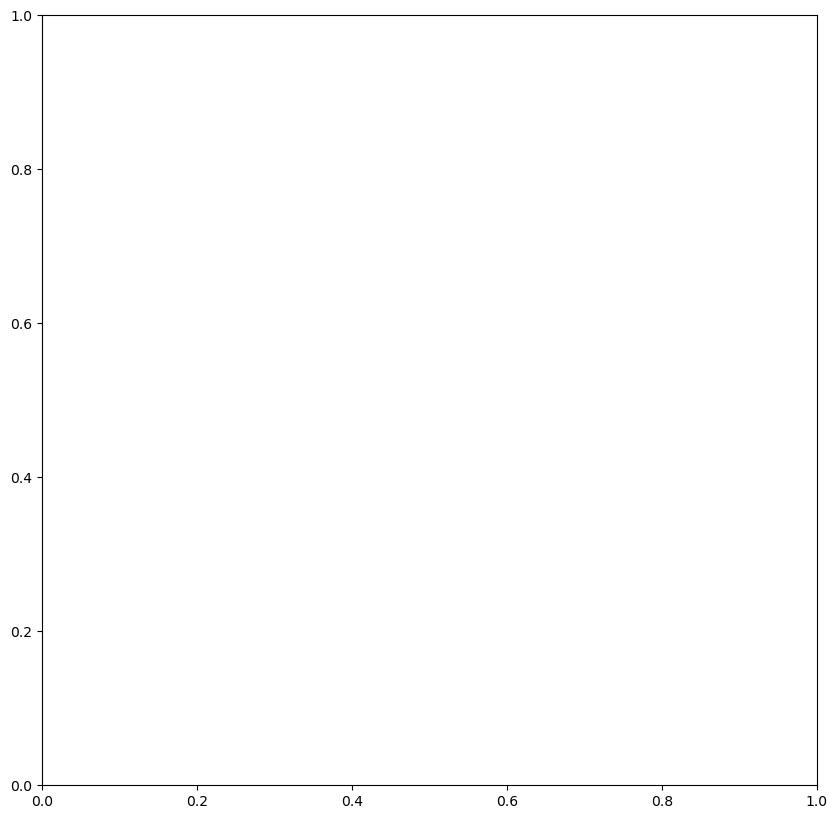

In [49]:
# ---------------------------------------------------------
# 1. Define the map window using four OSGB coordinates: xmin, xmax, ymin, ymax (metres).
sub_img_bbox = [275_000, 300_000, 275_000, 300_000]
# ---------------------------------------------------------
# 2. Prepare a Matplotlib canvas
#    One axis, 10 × 10 inches – large enough for legible detail.
fig, ax = plt.subplots(figsize=(10, 10))
# ---------------------------------------------------------
# 3. Draw a Sentinel-2 RGB composite
#    * input_img       : full multispectral stack
#    * img_bands       : [8 (NIR), 9 (red-edge), 3 (green)]
#    * img_stch        : cumulative histogram stretch for contrast
#    * bbox            : clip to the subset
#    * show_scale_bar  : adds a 5 km bar bottom-left
# ---------------------------------------------------------
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[8, 9, 3], 
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)

# ---------------------------------------------------------
# 4. Build a palette of distinct colours
#    CSS4 provides ~140 named colours; we convert the dict keys
#    to a list so random.choice can pick from it.
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

# Lists to store GeoPandas layers and their display colours
gp_vecs  = []
lyr_clrs = []

# ---------------------------------------------------------
# 5. Load each training layer and assign a random colour
#    * lyr_names        : list of class layers in the GeoPackage
#    * vec_train_file   : path to the training samples (GPKG)
for lyr_name in lyr_names:
    # Read the class layer as a GeoDataFrame
    gp_vecs.append(geopandas.read_file(vec_train_file, layer=lyr_name))
    # Pick a random CSS colour to fill that class
    lyr_clrs.append(random.choice(mpl_clrs))

# ---------------------------------------------------------
# 6. Overlay the training vectors on the RGB image
#    * gp_vecs         : list of GeoDataFrames (one per class)
#    * vec_fill_clrs   : matching list of fill colours
#    * vec_line_clrs   : outline colour (“black” for all)
#    * bbox            : ensures vectors are clipped to the subset
#    * show_scale_bar  : False – we already drew one above
# ---------------------------------------------------------
rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs="black",
    show_scale_bar=False,
)


# 3. Extract Training Samples

For the analysis, individual pixel values are extracted and stored in a [HDF5](https://www.hdfgroup.org/solutions/hdf5/) which allows for that data to be stored and manipulated (e.g., pixels values from multiple images can be merged).

To extract the training samples (i.e., individual pixel values) using the defined vector layer the vector layers first need to be rasterised to the same pixel grid as the input image(s). To simplify the implementation of this a helper function has been provided: `rsgislib.classification.get_class_training_data`. 



## 3.1 Define Images and Bands for Classification

Before the image pixel values can be extracted or the classification performed the relevant images and bands within those images need to be defined. Clearly, these need to defined identically for both extracting the image samples and the classification step. If these are not identically defined then the trained classifer will not work as intended which is likely to produce very poor classification results.

To define the images and bands a list of `rsgislib.imageutils.ImageBandInfo` objects is provided to the relevant RSGISLib functions:
Check the [LINK](http://rsgislib.org/rsgislib_imageutils.html#rsgislib.imageutils.ImageBandInfo) to better understand the rsgislib.imageutils.ImageBandInfo Class.


In [50]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], './Data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif')]


## 3.2 Define the classes and the vector samples

The Random-Forest helper routine expects a **list of `ClassVecSamplesInfoObj` objects**—one per land-cover class.  
Each object tells RSGISLib where to fetch the training vectors and where to store the pixel samples it extracts.

| Parameter | Meaning | Practical note |
|-----------|---------|----------------|
| `id` | Integer **label written to the classified raster**. Keep the sequence compact (e.g. 1 – 10) to simplify re-mapping later. |
| `class_name` | Short, machine-friendly name (lowercase, underscores). Used as the group name inside the HDF5 sample file. |
| `vec_file` | Path to the GeoPackage that holds **all** training layers. |
| `vec_lyr` | Exact layer name inside that GeoPackage for this class. |
| `file_h5` | Name of the **HDF5 file** RSGISLib will create to cache the extracted pixel samples (one file per class keeps things tidy). |

The folloing cell instantiates ten such objects—one for each thematic class in our legend—and append them to the `class_vec_sample_info` list.  
Feel free to add or remove entries as long as the IDs remain unique and the vector-layer names match those in the GeoPackage.



In [17]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
artificial_surfaces_h5 = "artificial_surfaces_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="artificial_surfaces",
        vec_file=vec_train_file,
        vec_lyr="Artificial_Surfaces",
        file_h5=artificial_surfaces_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bare_rock_sand_h5 = "bare_rock_sand_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="bare_rock_sand",
        vec_file=vec_train_file,
        vec_lyr="Bare_Rock_Sand",
        file_h5=bare_rock_sand_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
conifer_forest_h5 = "conifer_forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="conifer_forest",
        vec_file=vec_train_file,
        vec_lyr="Conifer_Forest",
        file_h5=conifer_forest_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
deciduous_forest_h5 = "deciduous_forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="deciduous_forest",
        vec_file=vec_train_file,
        vec_lyr="Deciduous_Forest",
        file_h5=deciduous_forest_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
grass_long_h5 = "grass_long_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="grass_long",
        vec_file=vec_train_file,
        vec_lyr="Grass_Long",
        file_h5=grass_long_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
grass_short_h5 = "grass_short_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=6,
        class_name="grass_short",
        vec_file=vec_train_file,
        vec_lyr="Grass_Short",
        file_h5=grass_short_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
nonphoto_veg_h5 = "nonphoto_veg_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=7,
        class_name="nonphoto_veg",
        vec_file=vec_train_file,
        vec_lyr="NonPhotosynthetic_Vegetation",
        file_h5=nonphoto_veg_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
scrub_h5 = "scrub_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=8,
        class_name="scrub",
        vec_file=vec_train_file,
        vec_lyr="Scrub",
        file_h5=scrub_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
water_h5 = "water_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=9,
        class_name="water",
        vec_file=vec_train_file,
        vec_lyr="Water_Training",
        file_h5=water_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
bracken_h5 = "bracken_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=10, #Integer class code (here 10). This is what you will see in the classified raster (e.g. pixels with value 10 = bracken).
        class_name="bracken", #short label stored as an attribute in the sample file.
        vec_file=vec_train_file,  #path to the GeoPackage holding all classes
        vec_lyr="Bracken",  #Exact layer name inside that GeoPackage for “bracken”.
        file_h5=bracken_h5,  # Filename that will hold the pixel samples extracted for class 10.
    )
)
## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303ca4410>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe3038efd90>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303a66b90>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303a3ea90>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303a3ffd0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303917bd0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303917ad0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe303915910>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe3039159d0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7fe304a4d650>]


When you `print()` a `ClassVecSamplesInfoObj` you only get the default Python output  
`<rsgislib.classification.ClassVecSamplesInfoObj object at 0x…>`, which is little more than the memory address.  
To **see the actual content** of the object we need to query its attributes directly.

The following chunk:

1. Stores the very first entry in the list (`class_vec_sample_info[0]`) as `obj`.  
2. Calls **`vars(obj)`** (or equivalently `obj.__dict__`) to dump every attribute as a tidy Python dictionary.

This makes it crystal-clear which `id`, `class_name`, vector layer and HDF5 filename are associated with that training class.







In [18]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__


{'id': 1,
 'class_name': 'artificial_surfaces',
 'vec_file': './Data/aber_sen2_cls_training.gpkg',
 'vec_lyr': 'Artificial_Surfaces',
 'file_h5': 'artificial_surfaces_smpls.h5'}

#### What does `obj.__dict__` actually do?

Every “normal” Python object keeps its **instance attributes** in a hidden dictionary called `__dict__`.  
When you access or assign `obj.some_attr`, Python is really performing a lookup or update in that dictionary.

Calling `obj.__dict__` therefore returns a live `dict` containing **all user-defined attributes** and their current values:

```python
{
    'id'        : 1,
    'class_name': 'artificial_surfaces',
    'vec_file'  : '/path/to/training.gpkg',
    'vec_lyr'   : 'Artificial_Surfaces',
    'file_h5'   : 'artificial_surfaces_smpls.h5'
}


## 3.3 Create a temporary output directory

The helper function requires a directory for temporary outputs (e.g., rastered vector layers) to be written to during the processing. The following code will test as to whether the directory already exists and if not it will created it:

In [19]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

## 3.4 Perform Sample Extraction

The next step will now use the `rsgislib.classification.get_class_training_data` helper function to extract the sample data: Check the info about the function `get_class_training_data` [HERE](http://rsgislib.org/rsgislib_classification.html#rsgislib.classification.get_class_training_data) and identify the fntion parameters and expected output.


In [20]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running R

See the returned class samples info object. Guide your analysis identifying the elementos of
a ClassSimpleInfoObj [HERE](http://rsgislib.org/rsgislib_classification.html#rsgislib.classification.ClassSimpleInfoObj)

In [21]:
# Output the returned class samples info object 
cls_smpls_info



{'artificial_surfaces': 1: artificial_surfaces_smpls.h5, (82, 159, 61),
 'bare_rock_sand': 2: bare_rock_sand_smpls.h5, (146, 9, 17),
 'conifer_forest': 3: conifer_forest_smpls.h5, (224, 189, 228),
 'deciduous_forest': 4: deciduous_forest_smpls.h5, (86, 96, 73),
 'grass_long': 5: grass_long_smpls.h5, (98, 210, 196),
 'grass_short': 6: grass_short_smpls.h5, (52, 119, 16),
 'nonphoto_veg': 7: nonphoto_veg_smpls.h5, (70, 26, 213),
 'scrub': 8: scrub_smpls.h5, (166, 112, 84),
 'water': 9: water_smpls.h5, (4, 143, 19),
 'bracken': 10: bracken_smpls.h5, (88, 65, 125)}

## 3.5 Define Class Colours

It is useful to manual define colours for classes is it makes it much easier for the end user to interpret the map. Colours are define as Red, Green and Blue (RGB) values between 0-255. There are many tools (e.g., [RapidTables](https://www.rapidtables.com/web/color/RGB_Color.html)) to look up colour online (try searching 'Colour picker'). 


In [22]:
cls_smpls_info["artificial_surfaces"].red = 180
cls_smpls_info["artificial_surfaces"].green = 180
cls_smpls_info["artificial_surfaces"].blue = 180

cls_smpls_info["bare_rock_sand"].red = 131
cls_smpls_info["bare_rock_sand"].green = 250
cls_smpls_info["bare_rock_sand"].blue = 252

cls_smpls_info["conifer_forest"].red = 0
cls_smpls_info["conifer_forest"].green = 105
cls_smpls_info["conifer_forest"].blue = 16

cls_smpls_info["deciduous_forest"].red = 62
cls_smpls_info["deciduous_forest"].green = 168
cls_smpls_info["deciduous_forest"].blue = 78

cls_smpls_info["grass_long"].red = 247
cls_smpls_info["grass_long"].green = 176
cls_smpls_info["grass_long"].blue = 32

cls_smpls_info["grass_short"].red = 252
cls_smpls_info["grass_short"].green = 231
cls_smpls_info["grass_short"].blue = 109

cls_smpls_info["nonphoto_veg"].red = 156
cls_smpls_info["nonphoto_veg"].green = 255
cls_smpls_info["nonphoto_veg"].blue = 215

cls_smpls_info["scrub"].red = 225
cls_smpls_info["scrub"].green = 114
cls_smpls_info["scrub"].blue = 247

cls_smpls_info["water"].red = 0
cls_smpls_info["water"].green = 0
cls_smpls_info["water"].blue = 255

cls_smpls_info["bracken"].red = 140
cls_smpls_info["bracken"].green = 255
cls_smpls_info["bracken"].blue = 0

cls_smpls_info

{'artificial_surfaces': 1: artificial_surfaces_smpls.h5, (180, 180, 180),
 'bare_rock_sand': 2: bare_rock_sand_smpls.h5, (131, 250, 252),
 'conifer_forest': 3: conifer_forest_smpls.h5, (0, 105, 16),
 'deciduous_forest': 4: deciduous_forest_smpls.h5, (62, 168, 78),
 'grass_long': 5: grass_long_smpls.h5, (247, 176, 32),
 'grass_short': 6: grass_short_smpls.h5, (252, 231, 109),
 'nonphoto_veg': 7: nonphoto_veg_smpls.h5, (156, 255, 215),
 'scrub': 8: scrub_smpls.h5, (225, 114, 247),
 'water': 9: water_smpls.h5, (0, 0, 255),
 'bracken': 10: bracken_smpls.h5, (140, 255, 0)}

## 3.6 How many training samples were extracted:

### 🔍 Sample-count sanity check

Before we train the classifier it is good practice to confirm *how many* pixel samples have actually been extracted for each land-cover class.  
The loop in the next cell performs that diagnostic in four straightforward steps:

1. **Iterate over the class dictionary** –  
   `cls_smpls_info` is a dictionary whose keys are the class names (`"water"`, `"scrub"`, *etc.*) and whose values are the corresponding `ClassVecSamplesInfoObj` entries you defined earlier.

2. **Retrieve the HDF5 file for each class** –  
   For the current key (`cls_name`) we pull `file_h5`, which is the path to the `.h5` file holding the spectral samples for that class (e.g. `"water_smpls.h5"`).

3. **Count the samples** –  
   `rsgislib.classification.get_num_samples()` opens the HDF5 file, looks at the `samples` dataset inside, and returns the number of rows/pixels stored.

4. **Print a tidy summary line** –  
   The `print()` produces output such as  
   `water: 3124`  
   `scrub: 587`  
   allowing you to spot empty classes, extreme imbalance or unexpectedly large sample sets.

> **Why is this useful?**  
> * Ensures no class was missed due to a typo in the layer name.  
> * Highlights class imbalance so you can address it **before** model fitting.  
> * Provides a rough idea of training time—thousands of samples per class are usually fine; tens of thousands may warrant down-sampling.



In [23]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

artificial_surfaces: 454
bare_rock_sand: 5392
conifer_forest: 3335
deciduous_forest: 4021
grass_long: 1264
grass_short: 622
nonphoto_veg: 1989
scrub: 5961
water: 34232
bracken: 1399


Observing the number of samples which are available for the classes there are a number of things which could be done. First, the samples should be balance (i.e., the same number per-class) and this would require using the class with the minimum of samples as the reference for defining the number of testing, training and validation samples. Alternatively, the sample data can be oversampled or there are algorithms which attempt to generate artifical training samples (see the functions within the `rsgislib.classification.classimblearn` module which make use of the [imbalanced-learn](https://imbalanced-learn.org) library.

For this tutorial, things will be kept simple and the class (artificial_surfaces) with the lowest number of samples will be used to define the number of samples for each class:

 * Training: 350
 * Validation: 50
 * Testing: 50
 
 The samples are randomly selected from the population of input samples.


## 3.7 Balance and Extract Training / Validation and Testing datasets

Again a helper function (`rsgislib.classication.create_train_valid_test_sets`) has been provided which will make it simplier to perform this analysis. For this a list of `rsgislib.classification.ClassInfoObj` objects needs to be defined which specifies the file names for the training, validation and testing HDF5 files.

After extracting raw pixel samples for every class we must **partition them into three independent subsets**:

| Subset | Purpose |
|--------|---------|
| **Training** | Fit the Random-Forest parameters. | 
| **Validation** | Tune hyper-parameters, spot overfitting. |
| **Testing** | Provide an unbiased accuracy figure at the very end.  |

RSGISLib offers two convenience helpers that automate this workflow:

1. **`get_class_info_dict`**  
   Converts our current dictionary of **`ClassSimpleInfoObj`** (one HDF5 of *all* samples per class) into a dictionary of **`ClassInfoObj`** that already includes *three* HDF5 filenames per class—`*_train.h5`, `*_valid.h5`, `*_test.h5`.

2. **`create_train_valid_test_sets`**  
   Reads those filenames, splits the samples accordingly, and writes the three files.

The cell that follows accomplishes step 1:

* We define an output directory (`smpls_dir`) where the split files will be written.
* `get_class_info_dict(cls_smpls_info, smpls_dir)` loops over each entry in `cls_smpls_info`, appends the suffixes `"_train"`, `"_valid"` and `"_test"` to the original sample filename, and returns the new dictionary **`cls_smpls_fnl_info`**.



In [24]:
# Define the output directory and create if it does not exist:
smpls_dir = "./cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

print("\n keys",cls_smpls_fnl_info.keys())

# print the values of artificail_surfaces
print("\n keys",cls_smpls_fnl_info["artificial_surfaces"])

0=1: (Train:./cls_smpls/artificial_surfaces_smpls_train.h5, Test:./cls_smpls/artificial_surfaces_smpls_test.h5, Valid:./cls_smpls/artificial_surfaces_smpls_valid.h5), (180, 180, 180)
1=2: (Train:./cls_smpls/bare_rock_sand_smpls_train.h5, Test:./cls_smpls/bare_rock_sand_smpls_test.h5, Valid:./cls_smpls/bare_rock_sand_smpls_valid.h5), (131, 250, 252)
2=3: (Train:./cls_smpls/conifer_forest_smpls_train.h5, Test:./cls_smpls/conifer_forest_smpls_test.h5, Valid:./cls_smpls/conifer_forest_smpls_valid.h5), (0, 105, 16)
3=4: (Train:./cls_smpls/deciduous_forest_smpls_train.h5, Test:./cls_smpls/deciduous_forest_smpls_test.h5, Valid:./cls_smpls/deciduous_forest_smpls_valid.h5), (62, 168, 78)
4=5: (Train:./cls_smpls/grass_long_smpls_train.h5, Test:./cls_smpls/grass_long_smpls_test.h5, Valid:./cls_smpls/grass_long_smpls_valid.h5), (247, 176, 32)
5=6: (Train:./cls_smpls/grass_short_smpls_train.h5, Test:./cls_smpls/grass_short_smpls_test.h5, Valid:./cls_smpls/grass_short_smpls_valid.h5), (252, 231, 109

> Keep in mind that, so far, no hdf5 with train or test or validation data has been created.
> 
> Once `cls_smpls_fnl_info` is created, the subsequent code block will call `create_train_valid_test_sets` to perform the actual stratified split.

Run the create_train_valid_test_sets helper function to
create the train, valid and test datasets

Check how the classification.create_train_valid_test_sets works at this [LINK](http://rsgislib.org/rsgislib_classification.html#rsgislib.classification.create_train_valid_test_sets)

In [26]:
# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 50, 50, 350
)

You now have three HDF5 files for each class (look within the `cls_smpls` directory) with these defining the pixels extracted from the scene for training, validating and testing the classifier. 

If you want to see what is within one of these HDF5 files you can use the h5dump command as show below (note, when using a jupyter notebook a line starting with `!` means it will be run as a command tool rather than Python code.

Within the HDF5 file you can see the that there are 51 samples and that each as 10 values (i.e., the Sentinel-2 bands we specified to be extracted earlier). 


In [27]:
!h5dump cls_smpls/grass_long_smpls_valid.h5

HDF5 "cls_smpls/grass_long_smpls_valid.h5" {
GROUP "/" {
   GROUP "DATA" {
      DATASET "DATA" {
         DATATYPE  H5T_IEEE_F32LE
         DATASPACE  SIMPLE { ( 51, 10 ) / ( H5S_UNLIMITED, 10 ) }
         DATA {
         (0,0): 36, 63, 29, 114, 439, 564, 584, 609, 220, 97,
         (1,0): 48, 89, 53, 167, 517, 643, 677, 715, 280, 137,
         (2,0): 35, 64, 32, 122, 460, 599, 627, 656, 201, 88,
         (3,0): 34, 62, 31, 114, 433, 556, 576, 612, 217, 94,
         (4,0): 41, 84, 39, 149, 550, 711, 752, 766, 266, 126,
         (5,0): 40, 79, 40, 146, 520, 674, 709, 738, 260, 123,
         (6,0): 36, 72, 32, 129, 519, 680, 712, 729, 245, 106,
         (7,0): 33, 62, 26, 111, 482, 635, 661, 686, 238, 97,
         (8,0): 34, 63, 31, 115, 443, 570, 599, 631, 227, 99,
         (9,0): 36, 64, 28, 113, 442, 570, 592, 615, 212, 92,
         (10,0): 34, 63, 31, 115, 443, 570, 599, 631, 227, 99,
         (11,0): 37, 68, 33, 116, 456, 592, 617, 640, 276, 124,
         (12,0): 40, 70, 34, 119, 4

# 4. Train the Classifier


## 4.1 Optimise Classifier Parameters

Machine learning algorithms have many parameters, which can alter the way the classifier runs or the way it represents the feature space. These parameters can significantly alter the classification result from the classifier. It is therefore important that we optimise the parameters of the classifier to best suit the problem being solved. 

The first step is to define the search space, i.e., the parameters to be searched and what values to try for those parameters.  The next code cell performs a **systematic search for the best Random-Forest settings** before we train the final model.

1. **Define the search grid**  
   ```python
   grid_search = GridSearchCV(
       RandomForestClassifier(),
       param_grid={
           "n_estimators": [10, 20, 50, 100, 150, 200],
           "max_depth"   : [4, 8, 10, 12, 14, 16],
       },
   )

Mor info at: 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV


In [51]:
print(cls_smpls_fnl_info)

{'artificial_surfaces': 0=1: (Train:./cls_smpls/artificial_surfaces_smpls_train.h5, Test:./cls_smpls/artificial_surfaces_smpls_test.h5, Valid:./cls_smpls/artificial_surfaces_smpls_valid.h5), (180, 180, 180), 'bare_rock_sand': 1=2: (Train:./cls_smpls/bare_rock_sand_smpls_train.h5, Test:./cls_smpls/bare_rock_sand_smpls_test.h5, Valid:./cls_smpls/bare_rock_sand_smpls_valid.h5), (131, 250, 252), 'conifer_forest': 2=3: (Train:./cls_smpls/conifer_forest_smpls_train.h5, Test:./cls_smpls/conifer_forest_smpls_test.h5, Valid:./cls_smpls/conifer_forest_smpls_valid.h5), (0, 105, 16), 'deciduous_forest': 3=4: (Train:./cls_smpls/deciduous_forest_smpls_train.h5, Test:./cls_smpls/deciduous_forest_smpls_test.h5, Valid:./cls_smpls/deciduous_forest_smpls_valid.h5), (62, 168, 78), 'grass_long': 4=5: (Train:./cls_smpls/grass_long_smpls_train.h5, Test:./cls_smpls/grass_long_smpls_test.h5, Valid:./cls_smpls/grass_long_smpls_valid.h5), (247, 176, 32), 'grass_short': 5=6: (Train:./cls_smpls/grass_short_smpls_t

In [28]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 50, 100, 150, 200]})
Training data size: 534 x 10
Best score was 0.9587727032269442 and has parameters {'max_depth': 14, 'n_estimators': 50}.


/opt/miniconda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## 4.2 Train Optimised Classifier

Now we have the optimised classifier parameters we can train on the full dataset. 


In [29]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 3540 x 10
Testing data size: 534 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 99.97%
Classifier Test Score = 98.13%


(0.9997175141242938, 0.9812734082397003)

# 5. Apply Classifier

You can now used the trained classifier to class the input image data. Note, the valid mask image that was defined at the top of the notebook is used to define which pixels are classified by the classifier. 

In [30]:
out_cls_img = "sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_cls.kea"
out_scr_img = "sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_cls_score.kea"

rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,
    sk_classifier,
    in_msk_img=in_msk_img,
    img_msk_val=1,
    img_file_info=img_band_info,
    out_class_img=out_cls_img,
    gdalformat="KEA",
    class_clr_names=True,
    out_score_img=out_scr_img,
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.










Apply Colour to class 'artificial_surfaces'
Apply Colour to class 'bare_rock_sand'
Apply Colour to class 'conifer_forest'
Apply Colour to class 'deciduous_forest'
Apply Colour to class 'grass_long'
Apply Colour to class 'grass_short'
Apply Colour to class 'nonphoto_veg'
Apply Colour to class 'scrub'
Apply Colour to class 'water'
Apply Colour to class 'bracken'


# 6. Visual Classification Results

Image Data Size: 3295 x 2880


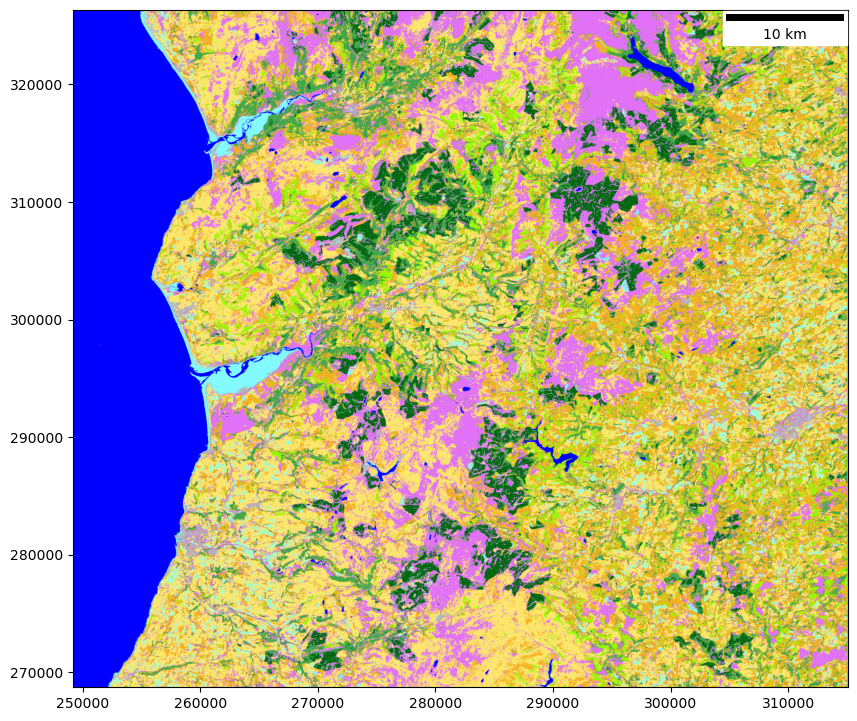

In [31]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)

## 6.1 Visualise Subsets

Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250


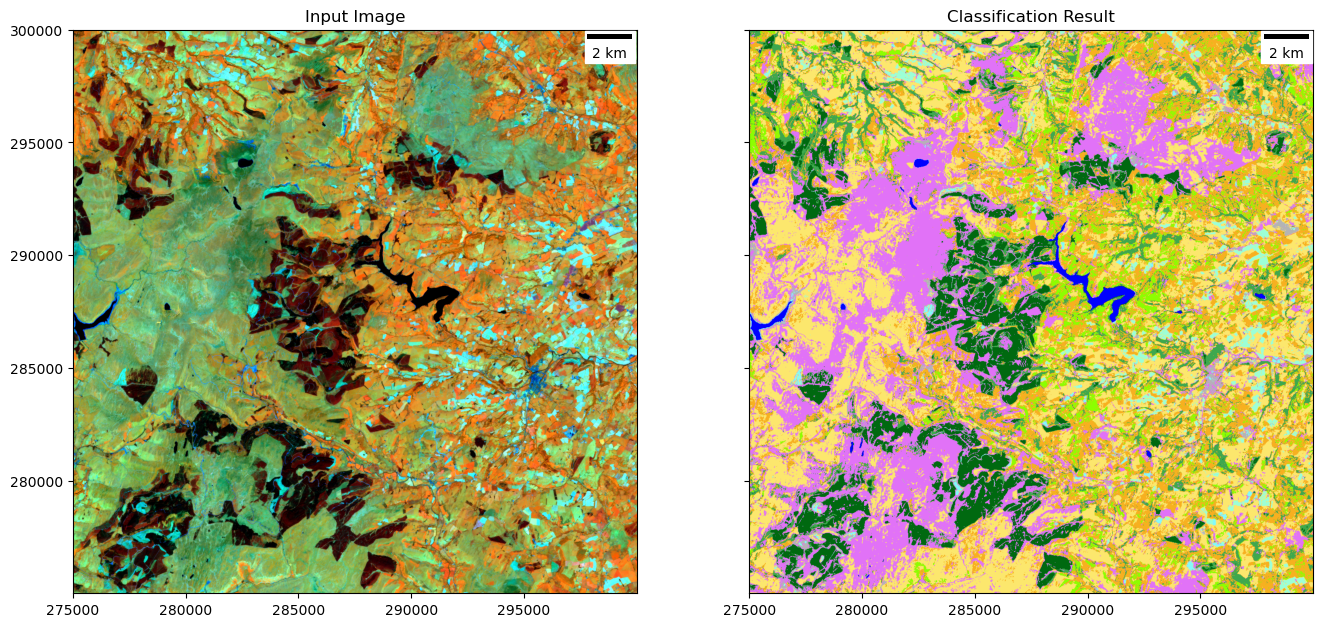

In [32]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [275000, 300000, 275000, 300000]
# sub_img_bbox = [255000, 280000, 275000, 300000]
# sub_img_bbox = [295000, 300000, 295000, 300000]

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Add the Sentinel-2 image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("Input Image")

# Add the classification to the seocnd axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result")

## 6.2 Create Legend

It is useful and normally required to have a legend to go along with your map. RSGISLib provides a some of functions which can be used to create such a legend from the image file using the attribute table information (i.e., class names column) and colour table.


Max. characters in class name: 19
Column width: 126
Image: 264 x  130


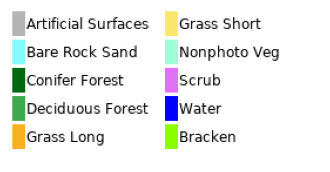

In [33]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import rsgislib.tools.plotting as rsg_plot

# ------------------------------------------------------------------
# 1. Build legend's dictionary based on raster
#    (ajusta 'class_names' si tu campo tiene otro nombre)
# ------------------------------------------------------------------
cls_info = rsg_plot.create_legend_info_dict(
    out_cls_img,
    cls_names_col="class_names",
    use_title_case=True,
    underscore_to_space=True,
)

# ------------------------------------------------------------------
# 2. Localizar una fuente TrueType que sí exista
#    DejaVu Sans viene con Matplotlib y está en casi todos los entornos
# ------------------------------------------------------------------
font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)

# ------------------------------------------------------------------
# 3. Dibujar la leyenda sobre un eje Matplotlib
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))

rsg_plot.create_legend_img_mpl_ax(
    ax,
    legend_info=cls_info,
    n_cols=2,          # número de columnas de la leyenda
    font=font_path,    # ruta TTF garantizada
)

plt.show()



## 6.3 Show Legend Alongside Map

Image Data Size: 1250 x 1250
Image Data Size: 1250 x 1250
Max. characters in class name: 19
Column width: 126
Image: 264 x  130


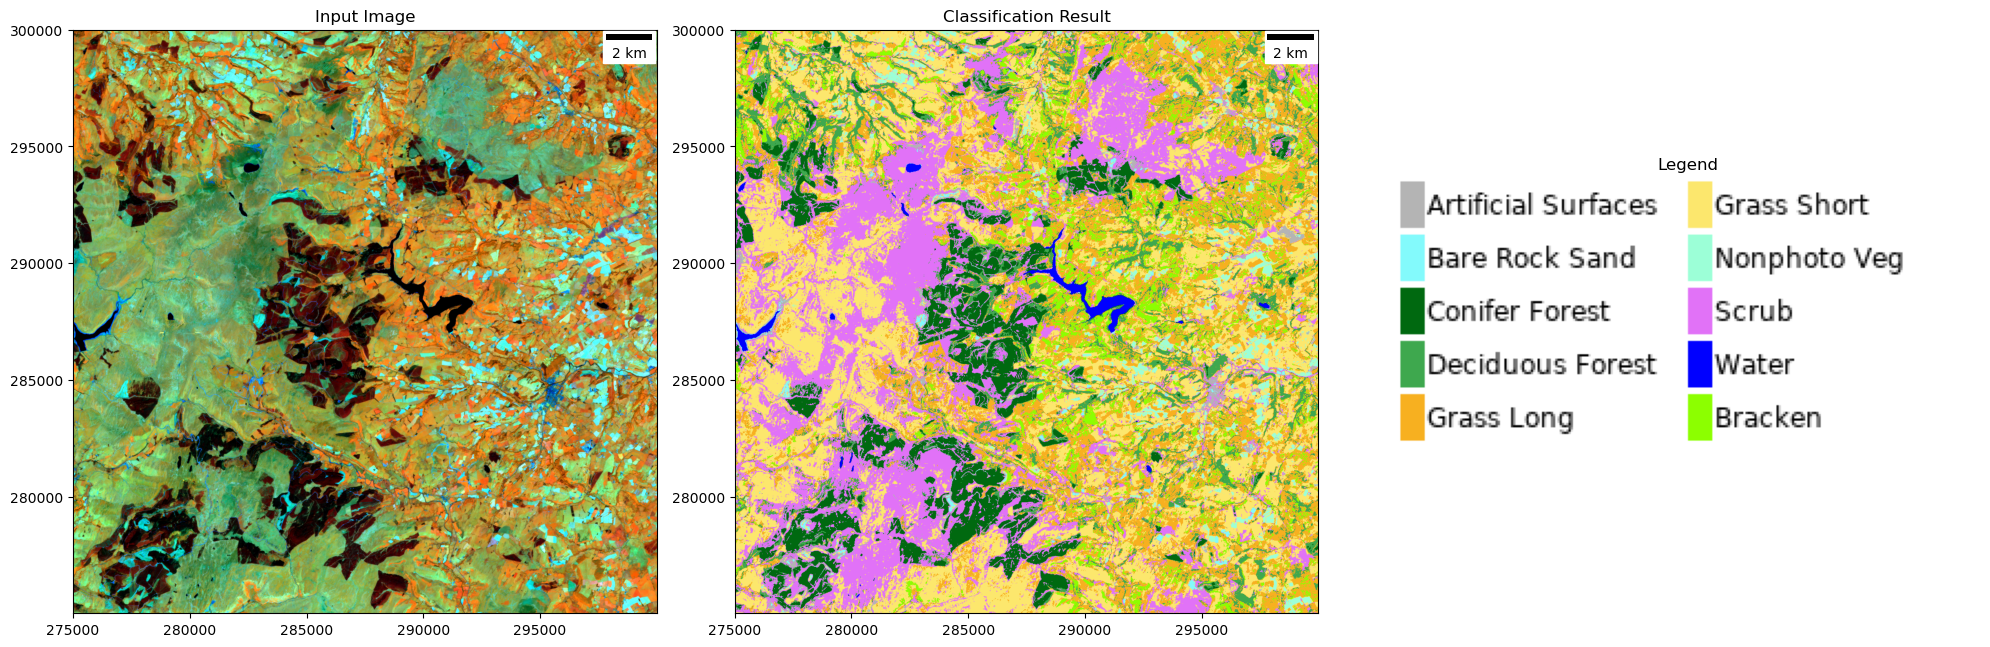

In [34]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import rsgislib.tools.mapping as rsg_map
import rsgislib.tools.plotting as rsg_plot

# ------------------------------------------------------------
# 1. Legend dictionary (already created earlier as `cls_info`)
#    cls_info = rsg_plot.create_legend_info_dict(...)
# ------------------------------------------------------------

# 2. Find a reliable TrueType font (DejaVu Sans ships with Matplotlib)
font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)

# 3. Build a 3-panel figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)

# ---- Sentinel-2 RGB composite (bands 8-9-3) ----
rsg_map.create_raster_img_map(
    ax1,
    input_img,                       # Sentinel-2 subset (KEA / GeoTIFF)
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.set_title("Input Image")

# ---- Pixel-based classification map ----
rsg_map.create_thematic_raster_map(
    ax2,
    out_cls_img,                     # Classified raster
    bbox=sub_img_bbox
)
ax2.set_title("Classification Result")

# ---- Legend panel (font argument prevents OSError) ----
rsg_plot.create_legend_img_mpl_ax(
    ax3,
    legend_info=cls_info,
    n_cols=2,                        # Columns in the legend table
    font=font_path                   # Explicit TTF path → no “cannot open resource”
)
ax3.set_title("Legend")

plt.tight_layout()
plt.show()


# 7.🌐Accuracy metrics estimation

Declare variables with path to points

In [35]:

vec_file = "./Data/test_points.gpkg"
vec_lyr = "cls_acc_assessment_pts_ref"

Create output Directories

In [36]:
out_pts_dir = "acc_pts"
if not os.path.exists(out_pts_dir):
    os.mkdir(out_pts_dir)
    
out_stats_dir = "acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)

To avoid overwriting and editting the input file provided we will first copy it into our output directory.
We also prepare a GeoJSON file containing the reference points that will be used for assessing the classification accuracy.

- `vec_refpts_file` defines the output file path for the reference points in **GeoJSON** format.
- `vec_refpts_lyr` is the name assigned to the layer within the vector file.

The function `rsgislib.vectorutils.vector_translate(...)` is used to export the specified vector layer (`vec_lyr`) from the original vector file (`vec_file`) into a new GeoJSON file (`vec_refpts_file`).  
We set the following parameters:
- `out_format="GeoJSON"`: the output format is GeoJSON.
- `del_exist_vec=True`: if a file with the same name already exists, it will be overwritten.

This output will later serve as a reference for validating the thematic classification.

In [39]:
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

rsgislib.vectorutils.vector_translate(vec_file, vec_lyr, vec_refpts_file, vec_refpts_lyr, out_format="GeoJSON", del_exist_vec=True)

Deleting: acc_pts/cls_acc_assessment_pts_ref.geojson



  1%|▎                          | 1/100 [00:00<00:02, 37.94it/s]


### 🖼️ Visualising the classification reference points over the satellite image
- First, we use the function `get_gdal_raster_mpl_imshow(...)` to read the raster image data and extract three selected bands (in this case bands 8, 9, and 3), which are suitable for a false colour composite.
- We then apply a standard deviation stretch (`stdev_stretch_np_arr(...)`) to enhance the visual appearance of the image. This stretch normalises the pixel values between 0 and 1, making them more suitable for display.
- Using Matplotlib, we plot the image and set its spatial extent so the axes reflect real-world coordinates.
- We also load the reference points from the GeoJSON file using `geopandas.read_file(...)` and clean the class labels to ensure consistency across the dataset.
- Finally, the reference points are plotted on top of the image. Each class is visualised with a different colour, helping to inspect their spatial distribution relative to land cover features.

This visual check is a useful qualitative step before performing quantitative accuracy assessment.

Image Data Size: 3295 x 2880


<Axes: >

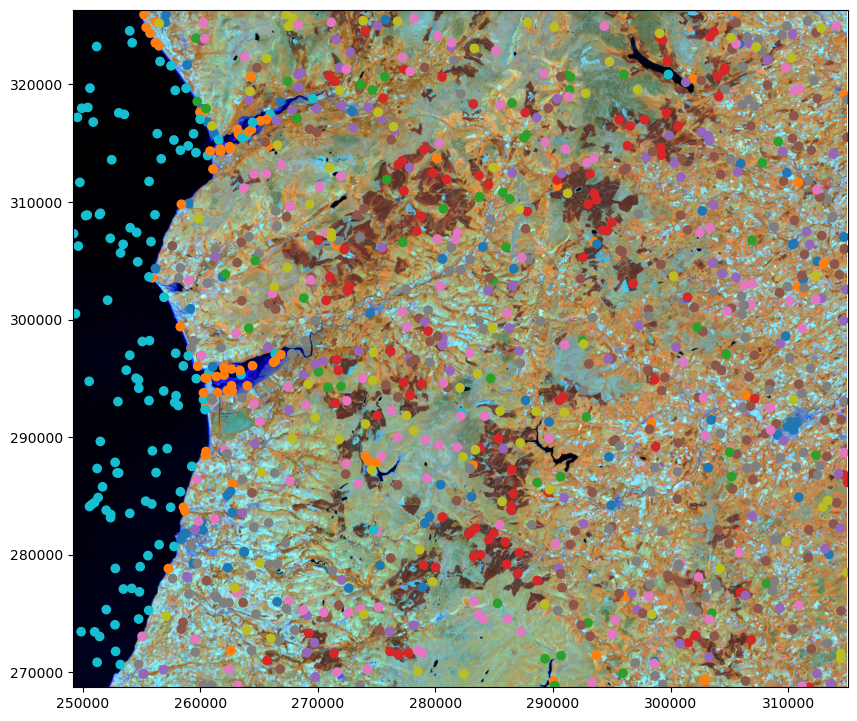

In [40]:
# Read image data
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Read points to geopandas dataframe
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf 



# Plot the plots over the image data
# Note. Points are randomly coloured by reference class
points_gdf.plot(ax=ax, column='ref_pts')


In [44]:
points_gdf

ref_pts            et_rl_cls                       geometry
0         bare_rock_sand  artificial_surfaces  POINT (293492.332 306597.255)
1    artificial_surfaces          grass_short  POINT (312462.332 304967.255)
2         bare_rock_sand         nonphoto_veg  POINT (306412.332 293567.255)
3    artificial_surfaces                scrub  POINT (259012.332 309877.255)
4    artificial_surfaces  artificial_surfaces  POINT (305842.332 323467.255)
..                   ...                  ...                            ...
995                water                water  POINT (250902.332 316807.255)
996                water                water  POINT (257912.332 297147.255)
997                water                water  POINT (249762.332 311677.255)
998                water                water  POINT (253712.332 295707.255)
999                water                water  POINT (252802.332 271797.255)

[1000 rows x 3 columns]

### 7.2. Populate Reference Points
Using the reference points we will use the rsgislib.classification.pop_class_info_accuracy_pts function to populate the classification from cls_et_refl.kea on to these points:

In [41]:
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="et_rl_cls",
    vec_ref_col=None,
    vec_process_col=None,
)

What has changed in the attribute table?

In [42]:
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf

ref_pts            et_rl_cls                       geometry
0         Bare_Rock_Sand  artificial_surfaces  POINT (293492.332 306597.255)
1    Artificial_Surfaces          grass_short  POINT (312462.332 304967.255)
2         Bare_Rock_Sand  artificial_surfaces  POINT (306412.332 293567.255)
3    Artificial_Surfaces  artificial_surfaces  POINT (259012.332 309877.255)
4    Artificial_Surfaces  artificial_surfaces  POINT (305842.332 323467.255)
..                   ...                  ...                            ...
995                Water                water  POINT (250902.332 316807.255)
996                Water                water  POINT (257912.332 297147.255)
997                Water                water  POINT (249762.332 311677.255)
998                Water                water  POINT (253712.332 295707.255)
999                Water                water  POINT (252802.332 271797.255)

[1000 rows x 3 columns]

In [43]:

points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Artificial_Surfaces": "artificial_surfaces"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Grass_Short": "grass_short"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Scrub": "scrub"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Grass_Short": "grass_short"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"NonPhoto_Veg": "nonphoto_veg"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Bare_Rock_Sand": "bare_rock_sand"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Grass_Long": "grass_long"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Bracken": "bracken"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Deciduous_Forest": "deciduous_forest"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Conifer_Forest": "conifer_forest"})
points_gdf["ref_pts"] = points_gdf["ref_pts"].replace({"Water": "water"})

8. Filter Valid Points
Some classifiers can produce no data regions and if those intersect with reference points then an error will occur when calculating the accuracy statistics so we need to remove those which we will do using geopandas. For points where there is no class (i.e., no data) in the input classification then the value "NA" is outputted into the attribute table and it is rows with an "NA" value that we want to remove.

In [45]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["et_rl_cls"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")


                 ref_pts            et_rl_cls                       geometry
0         bare_rock_sand  artificial_surfaces  POINT (293492.332 306597.255)
1    artificial_surfaces          grass_short  POINT (312462.332 304967.255)
2         bare_rock_sand  artificial_surfaces  POINT (306412.332 293567.255)
3    artificial_surfaces  artificial_surfaces  POINT (259012.332 309877.255)
4    artificial_surfaces  artificial_surfaces  POINT (305842.332 323467.255)
..                   ...                  ...                            ...
995                water                water  POINT (250902.332 316807.255)
996                water                water  POINT (257912.332 297147.255)
997                water                water  POINT (249762.332 311677.255)
998                water                water  POINT (253712.332 295707.255)
999                water                water  POINT (252802.332 271797.255)

[999 rows x 3 columns]


In [46]:


# Get unique values
print( points_gdf["ref_pts"].unique())


['bare_rock_sand' 'artificial_surfaces' 'nonphoto_veg' 'water' 'scrub'
 'grass_long' 'bracken' 'grass_short' 'deciduous_forest' 'conifer_forest']


Calculate Classification Accuracy
RSGISLib provides a couple of functions for this and we will use the calc_acc_metrics_vecsamples function.

In [47]:
# Import the calc_acc_metrics_vecsamples function from the 
# rsgislib.classification.classaccuracymetrics module.
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="ref_pts",
    cls_col="et_rl_cls",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{np.str_('artificial_surfaces'): {'precision': 0.55,
  'recall': 0.6666666666666666,
  'f1-score': 0.6027397260273972,
  'support': 66.0},
 np.str_('bare_rock_sand'): {'precision': 0.5764705882352941,
  'recall': 0.6621621621621622,
  'f1-score': 0.6163522012578616,
  'support': 74.0},
 np.str_('bracken'): {'precision': 0.6271186440677966,
  'recall': 0.7115384615384616,
  'f1-score': 0.6666666666666666,
  'support': 52.0},
 np.str_('conifer_forest'): {'precision': 0.9885057471264368,
  'recall': 0.8269230769230769,
  'f1-score': 0.900523560209424,
  'support': 104.0},
 np.str_('deciduous_forest'): {'precision': 0.8478260869565217,
  'recall': 0.7878787878787878,
  'f1-score': 0.8167539267015707,
  'support': 99.0},
 np.str_('grass_long'): {'precision': 0.6466666666666666,
  'recall': 0.6879432624113475,
  'f1-score': 0.6666666666666666,
  'support': 141.0},
 np.str_('grass_short'): {'precision': 0.5935483870967742,
  'recall': 0.7479674796747967,
  'f1-score': 0.6618705035971223,
  's

In [48]:
import pprint
cls_acc_stats_dict = rsgislib.tools.utils.read_json_to_dict(out_json_file)
pprint.pprint(cls_acc_stats_dict)

{'accuracy': 0.7307307307307307,
 'accuracy_conf_interval': [0.02301617684338589,
                            0.027507138178680703,
                            0.032699812222615324,
                            0.03620837576581439],
 'artificial_surfaces': {'f1-score': 0.6027397260273972,
                         'precision': 0.55,
                         'recall': 0.6666666666666666,
                         'support': 66.0},
 'bal_accuracy_score': 0.729278659421516,
 'bare_rock_sand': {'f1-score': 0.6163522012578616,
                    'precision': 0.5764705882352941,
                    'recall': 0.6621621621621622,
                    'support': 74.0},
 'bracken': {'f1-score': 0.6666666666666666,
             'precision': 0.6271186440677966,
             'recall': 0.7115384615384616,
             'support': 52.0},
 'class_area': {'artificial_surfaces': 61052400.0,
                'bare_rock_sand': 44942800.0,
                'bracken': 204262000.0,
                'conifer_forest'

### 8,🧪 Your task: Apply the workflow to your own dataset

Now it is your turn to apply this workflow using either your own dataset or a dataset provided by the instructor.

- You must follow the same steps to prepare the reference points, visualise them over a satellite image, and assess the classification results.
- Importantly, you are required to **test at least two additional machine learning models** (e.g. Support Vector Machines, k-Nearest Neighbours, Gradient Boosting, etc.) in addition to Random Forest.
- Use `GridSearchCV` to tune the hyperparameters of each model and evaluate their performance using the validation points.
- Based on the accuracy metrics, **choose the best-performing model** for your final classification.
- Explain each of the accuracy metrics presented, What do they mean?

**You will attach a report and your Jupuyter notebook executed**
